In [2]:
import os
import sys
import numpy as np
sys.path.append('/data/users1/mdoan4/babywire/gen_scripts/wirehead')
from wirehead import Runtime 
from pymongo import MongoClient

# Mongo config
DBNAME              = "babywire_test"
MONGOHOST           = "arctrdcn018.rs.gsu.edu"
client              = MongoClient("mongodb://" + MONGOHOST + ":27017")
db                  = client[DBNAME]

# Synthseg config
LABEL_MAP = np.asarray(
    [0, 0, 1, 2, 3, 4, 0, 5, 6, 0, 7, 8, 9, 10]
    + [11, 12, 13, 14, 15]
    + [0] * 6
    + [1, 16, 0, 17]
    + [0] * 12
    + [18, 19, 20, 21, 0, 22, 23]
    + [0, 24, 25, 26, 27, 28, 29, 0, 0, 18, 30, 0, 31]
    + [0] * 75
    + [3, 4]
    + [0] * 25
    + [20, 21]
    + [0] * 366,
    dtype="int",
).astype(np.uint8)

def merge_homologs(label):#, device):
    max_value = 31
    # idx = torch.arange(max_value + 1, dtype=torch.long).to(device)
    idx = np.arange(max_value+1)
    idx[31] = 17
    idx[30] = 16
    idx[29] = 15
    idx[28] = 14
    idx[27] = 10
    idx[26] = 9
    idx[25] = 8
    idx[24] = 7
    idx[23] = 6
    idx[22] = 5
    idx[21] = 4
    idx[20] = 3
    idx[19] = 2
    idx[18] = 1
    # return the corresponding values from idx
    return idx[label]

PATH_TO_DATA        = "/data/users1/mdoan4/babywire/babytrainingdata/"
DATA_FILES          = ["labeling2_inf10_final4.nii.gz"] # this is where you slap on more samples
PATH_TO_SYNTHSEG    = '/data/users1/mdoan4/wirehead/dependencies/synthseg'


# Create a generator function that yields desired samples
def create_generator(task_id, training_seg=None):
    """ Creates an iterator that returns data for mongo.
        Should contain all the dependencies of the brain generator
        Preprocessing should be applied at this phase 
        yields : tuple ( data: tuple ( data_idx: torch.tensor, ) , data_kinds : tuple ( kind : str)) """

    # 0. Optionally set up hardware configs
    hardware_setup()

    # 1. Declare your generator and its dependencies here
    sys.path.append(PATH_TO_SYNTHSEG)
    from SynthSeg.brain_generator import BrainGenerator
    training_seg = DATA_FILES[task_id % len(DATA_FILES)] if training_seg == None else training_seg
    brain_generator = BrainGenerator(PATH_TO_DATA + training_seg)
    print(f"Generator: SynthSeg is generating off {training_seg}",flush=True,)
    # 2. Run your generator in a loop, and pass in your preprocessing options
    while True:
        img, lab = preprocessing_pipe(brain_generator.generate_brain())
        # 3. Yield your data, which will automatically be pushed to mongo
        yield ((img, lab), ('data', 'label'))

def preprocessing_pipe(data):
    """ Set up your preprocessing options here, ignore if none are needed """
    img, lab = data
    img = preprocess_image_min_max(img) * 255
    img = img.astype(np.uint8)
    lab = preprocess_label(lab)
    lab = merge_homologs(lab)
    lab = lab.astype(np.uint8)
    return (img, lab) 

def hardware_setup():
    """ Clean slate to set up your hardware, ignore if none are needed """
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
    sys.path.append(PATH_TO_SYNTHSEG)
    pass

def preprocess_label(lab, label_map=LABEL_MAP):
    return label_map[lab]

def preprocess_image_min_max(img: np.ndarray) -> np.ndarray:
    "Min max scaling preprocessing for the range 0..1"
    img = (img - img.min()) / (img.max() - img.min())
    return img

# Extras
def my_task_id() -> int:
    """ Returns slurm task id """
    task_id = os.getenv(
        "SLURM_ARRAY_TASK_ID", "0"
    )  # Default to '0' if not running under Slurm
    return int(task_id)

# Function to check if this is the first job based on SLURM_ARRAY_TASK_ID
def is_first_job():
    return my_task_id() == 0

In [3]:
# 0. Optionally set up hardware configs
hardware_setup()
task_id = 0
# 1. Declare your generator and its dependencies here
sys.path.append(PATH_TO_SYNTHSEG)
from SynthSeg.brain_generator import BrainGenerator
#training_seg = None
#training_seg = DATA_FILES[task_id % len(DATA_FILES)] if training_seg == None else training_seg
training_seg = '../babytrainingdata/fixed/labeling2_inf10_final5.nii.gz'
brain_generator = BrainGenerator(PATH_TO_DATA + training_seg)
print(f"Generator: SynthSeg is generating off {training_seg}",flush=True,)

2024-05-28 14:13:36.927722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-05-28 14:13:37.096162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.34GiB deviceMemoryBandwidth: 648.29GiB/s
2024-05-28 14:13:37.096969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-05-28 14:13:37.098906: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-28 14:13:37.100574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-05-28 14:13:37.101116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-0

Compiling list of unique labels
processing 1/1


2024-05-28 14:13:38.593966: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2024-05-28 14:13:38.619262: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1996275000 Hz
2024-05-28 14:13:38.621911: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x66742d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-28 14:13:38.621926: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-28 14:13:38.742031: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6193e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 14:13:38.742046: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-05-28 14:13:38.743777: I tensorflow/core

Generator: SynthSeg is generating off ../babytrainingdata/fixed/labeling2_inf10_final5.nii.gz


In [4]:
img, lab = brain_generator.generate_brain()

2024-05-28 14:13:44.140470: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-28 14:20:07.473085: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cropped_tensor_slices(tensor, slice_dim=0, cmap='viridis', crop_percentile=10):
    # Create a copy of the tensor to avoid modifying the original
    data_for_processing = tensor.copy()

    # Thresholding (assuming background has very low values compared to the head)
    threshold = np.percentile(data_for_processing, crop_percentile)
    data_for_processing[data_for_processing < threshold] = 0

    # Find the bounding box around the head (non-zero region) in the filtered data
    indices = np.nonzero(data_for_processing)
    min_z, max_z = np.min(indices[0]), np.max(indices[0])
    min_y, max_y = np.min(indices[1]), np.max(indices[1])
    min_x, max_x = np.min(indices[2]), np.max(indices[2])

    # Crop the original tensor using the bounding box from the filtered data
    cropped_tensor = tensor[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1]

    # Determine the dimensions of the cropped tensor
    dim0, dim1, dim2 = cropped_tensor.shape

    # Determine the slicing dimensions based on the specified slice_dim
    if slice_dim == 0:
        num_slices = dim0
        slice_shape = (dim1, dim2)
    elif slice_dim == 1:
        num_slices = dim1
        slice_shape = (dim0, dim2)
    elif slice_dim == 2:
        num_slices = dim2
        slice_shape = (dim0, dim1)
    else:
        raise ValueError("Invalid slice_dim. Must be 0, 1, or 2.")

    # Calculate the grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_slices)))

    # Create a larger matrix to hold the slices
    R = np.zeros((grid_size * slice_shape[0], grid_size * slice_shape[1]))

    # Iterate over the slices and place them in the larger matrix
    for i in range(grid_size):
        for j in range(grid_size):
            slice_index = i * grid_size + j
            if slice_index < num_slices:
                if slice_dim == 0:
                    slice_data = cropped_tensor[slice_index, :, :]
                elif slice_dim == 1:
                    slice_data = cropped_tensor[:, slice_index, :]
                else:  # slice_dim == 2
                    slice_data = cropped_tensor[:, :, slice_index]
                R[i*slice_shape[0]:(i+1)*slice_shape[0], j*slice_shape[1]:(j+1)*slice_shape[1]] = slice_data

    # Plot the larger matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(R, cmap=cmap)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

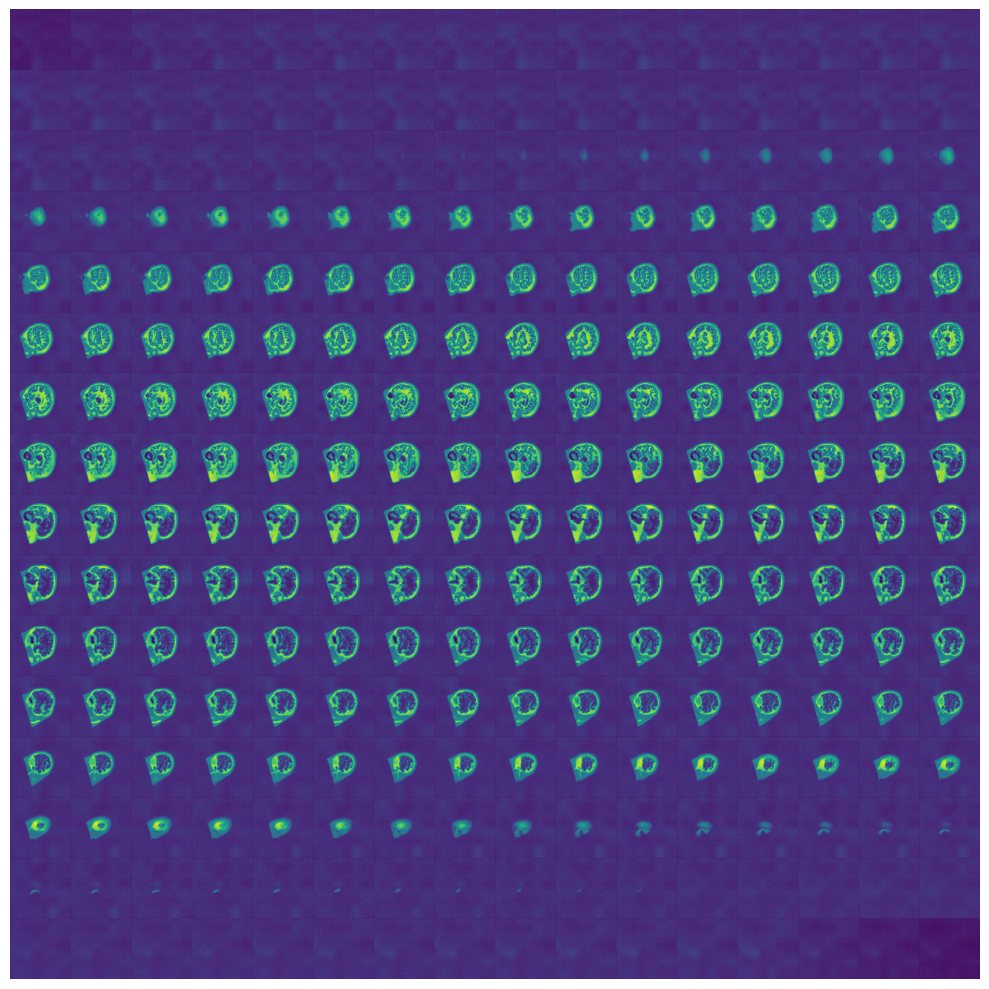

In [6]:
plot_cropped_tensor_slices(img)

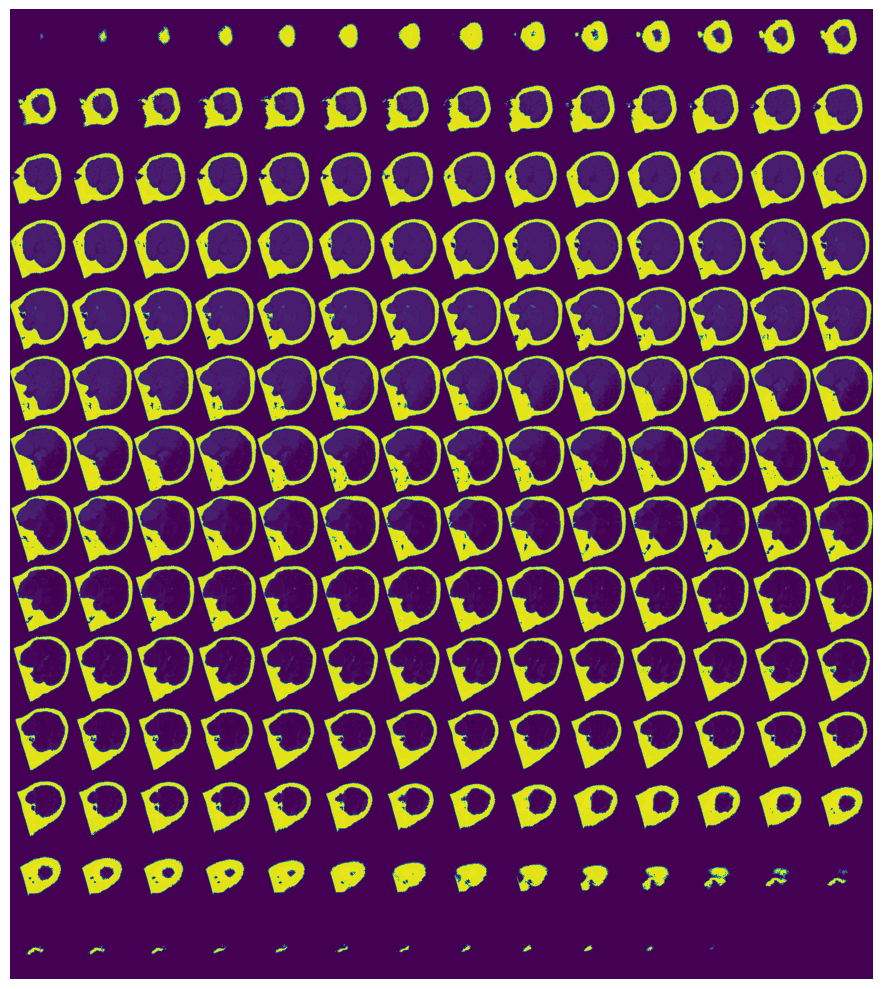

In [7]:
plot_cropped_tensor_slices(lab)

In [29]:
np.save('./saved/synthseg_baby_img.npy', img)
np.save('./saved/synthseg_baby_lab.npy', lab)

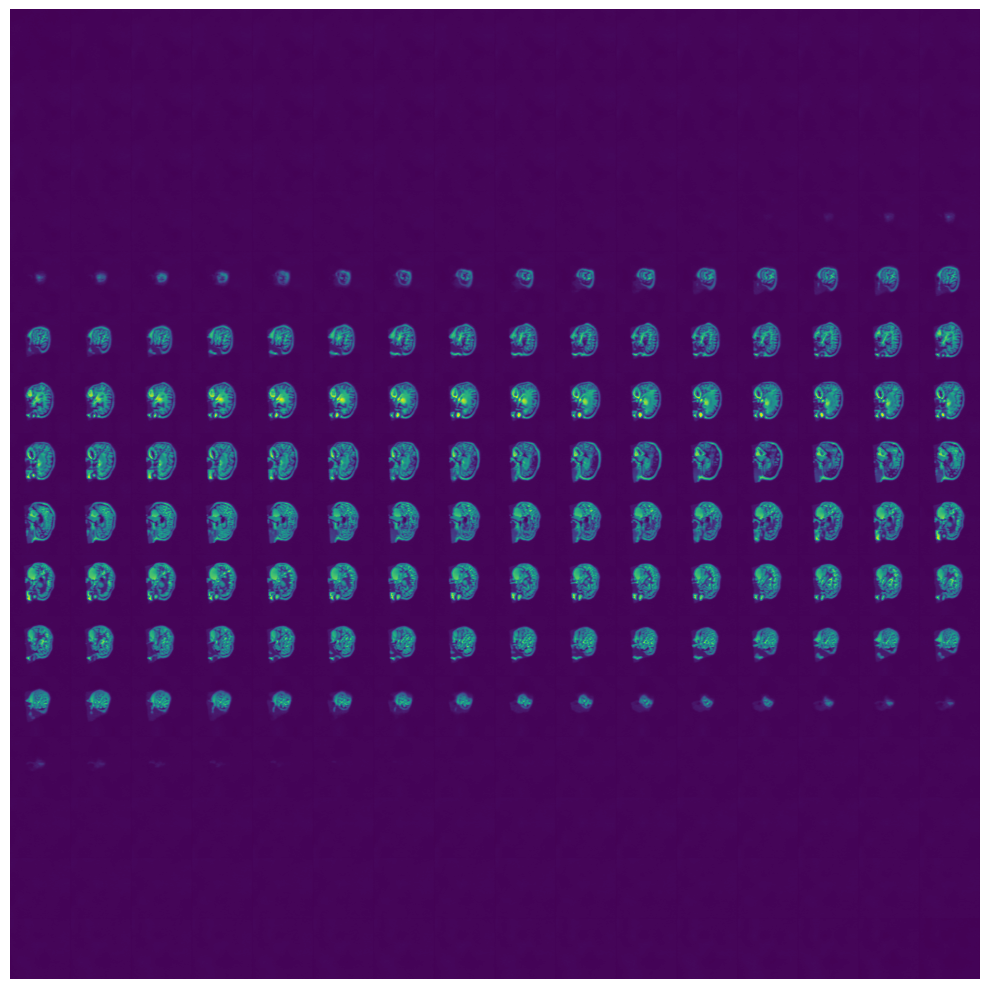

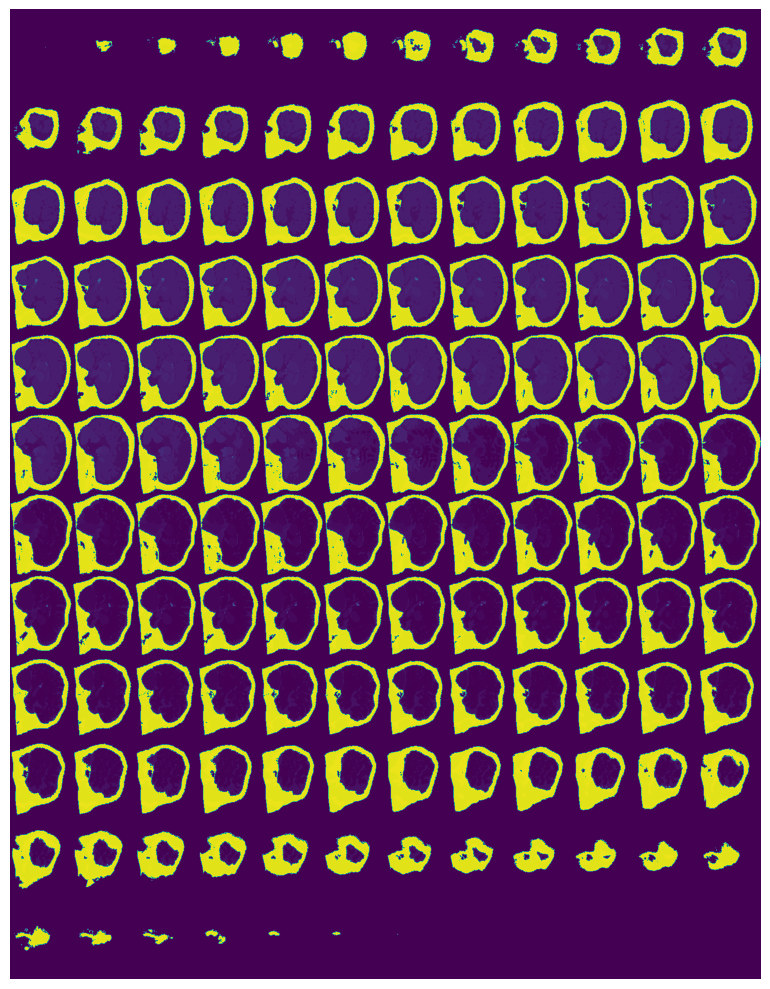

[  0   2   3   4   5   7   8  10  11  12  13  14  15  16  17  18  24  25
  26  28  30  41  42  43  44  46  47  49  50  51  52  53  54  57  58  60
  62  72  85 136 137 163 164 502 506 507 508 509 511 512 514 515 516 530]


In [12]:
img, lab = brain_generator.generate_brain()
plot_cropped_tensor_slices(img)
plot_cropped_tensor_slices(lab)
print(np.unique(lab))

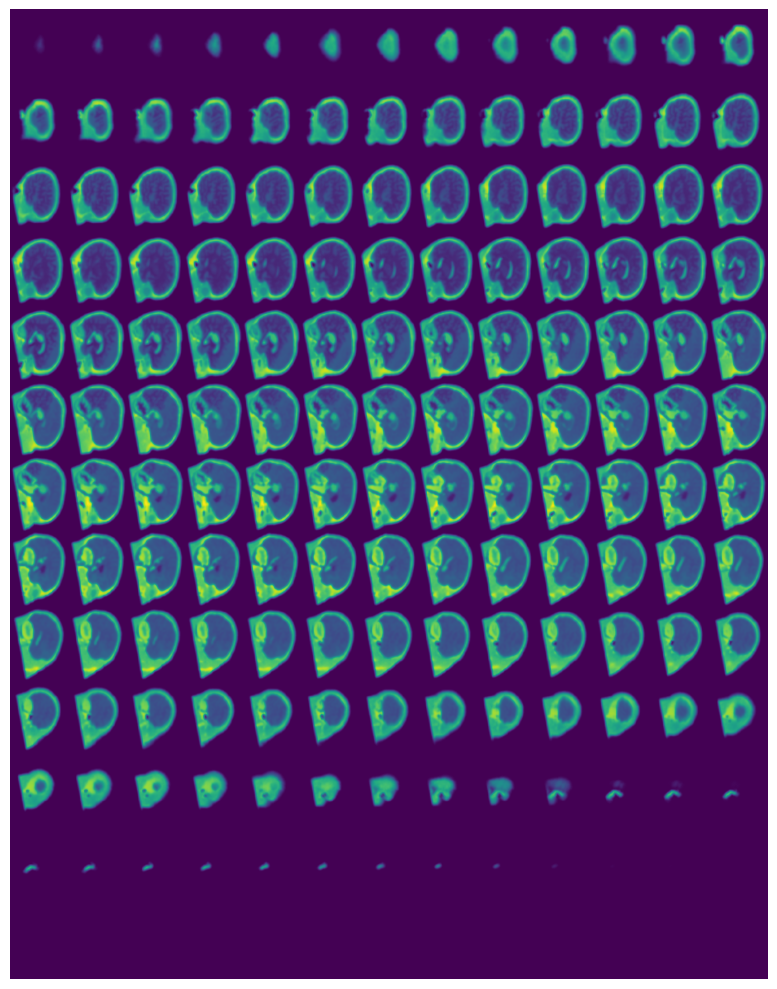

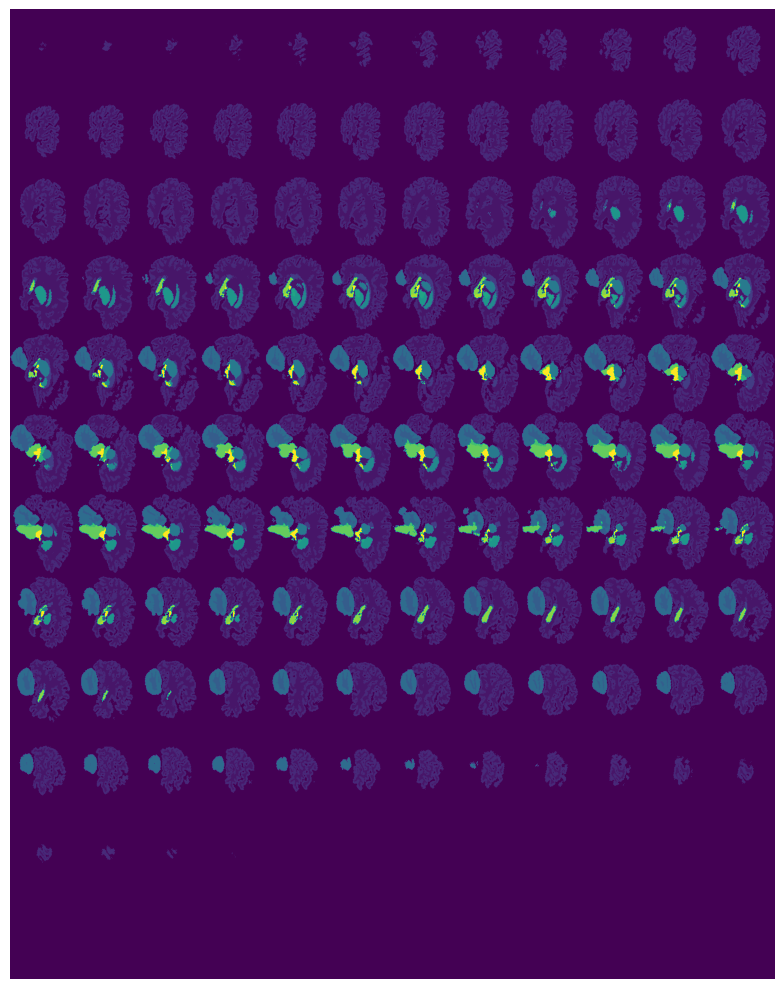

In [16]:
img, lab = preprocessing_pipe(brain_generator.generate_brain())
plot_cropped_tensor_slices(img)
plot_cropped_tensor_slices(lab)

In [ ]:
# 0. Raw out of synthseg
img0, lab0 = brain_generator.generate_brain()
plot_cropped_tensor_slices(img)
plot_cropped_tensor_slices(lab)

In [ ]:
# 1. Min max preprocessing
img1 = preprocess_image_min_max(img0) * 255
plot_cropped_tensor_slices(img1)

In [ ]:
# 2. Quantize to uint 8
img2 = img1.astype(np.uint8)
plot_cropped_tensor_slices(img2)

In [ ]:
# 3. Label remap
lab3 = preprocess_label(lab0)
plot_cropped_tensor_slices(lab3)

In [ ]:
# 3. Merge homologs
lab4 = merge_homologs(lab3)
plot_cropped_tensor_slices(lab4)

In [ ]:
import nibabel as nib

# Load the NIfTI file
nifti_file = '../babytrainingdata/labeling2_inf10_final4.nii.gz'
img = nib.load(nifti_file)

# Get the tensor data from the NIfTI image
tensor = img.get_fdata()

# Plot the cropped tensor slices
plot_cropped_tensor_slices(tensor)
print(np.unique(lab))

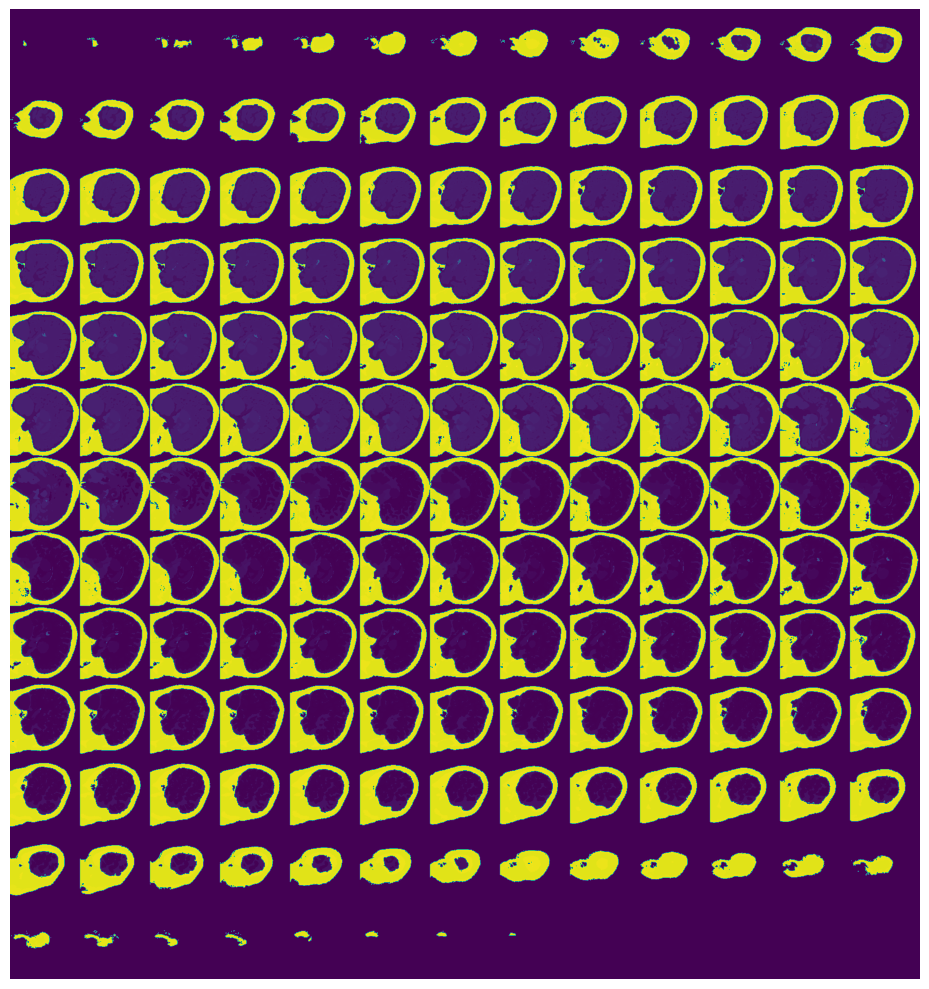

[  0.   2.   3.   4.   5.   7.   8.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  24.  25.  26.  28.  30.  41.  42.  43.  44.  46.  47.  49.
  50.  51.  52.  53.  54.  57.  58.  60.  62.  72.  85. 136. 137. 163.
 164. 502. 506. 507. 508. 509. 511. 512. 514. 515. 516. 530.]


In [4]:
import nibabel as nib

# Load the NIfTI file
nifti_file = '../babytrainingdata/fixed/labeling2_inf10_final5.nii.gz'
img = nib.load(nifti_file)

# Get the tensor data from the NIfTI image
tensor = img.get_fdata()

# Plot the cropped tensor slices
plot_cropped_tensor_slices(tensor)
print(np.unique(tensor))

In [8]:
slice0 = tensor[128][128]
print(slice0)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 507. 507. 507. 507. 507. 507. 507. 507. 507. 507. 507.
 507. 507. 507. 507. 507. 507. 507. 507. 507. 507. 507. 507. 507. 515.
 515. 515. 515. 515. 515. 515. 515. 515. 515. 515. 507. 515.  24.  24.
  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.
  24.  24.  24.  24.  24.  24.  24.  24.  24.   3.   3.   3.   2.   2.
   2.   2.   2.   2.   2.   2.   2.   2.   2.   4.   4.   4.   4.   4.
   4.   4.   4.   4.   2.   2.   2.   3.   3.   3.   3.   3.   2.   2.
   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.
   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.  24.  24.  24.
  24.  24.  24.  24.  24.  24.  24.  24. 515. 515. 515. 515. 507. 507.
 507. 

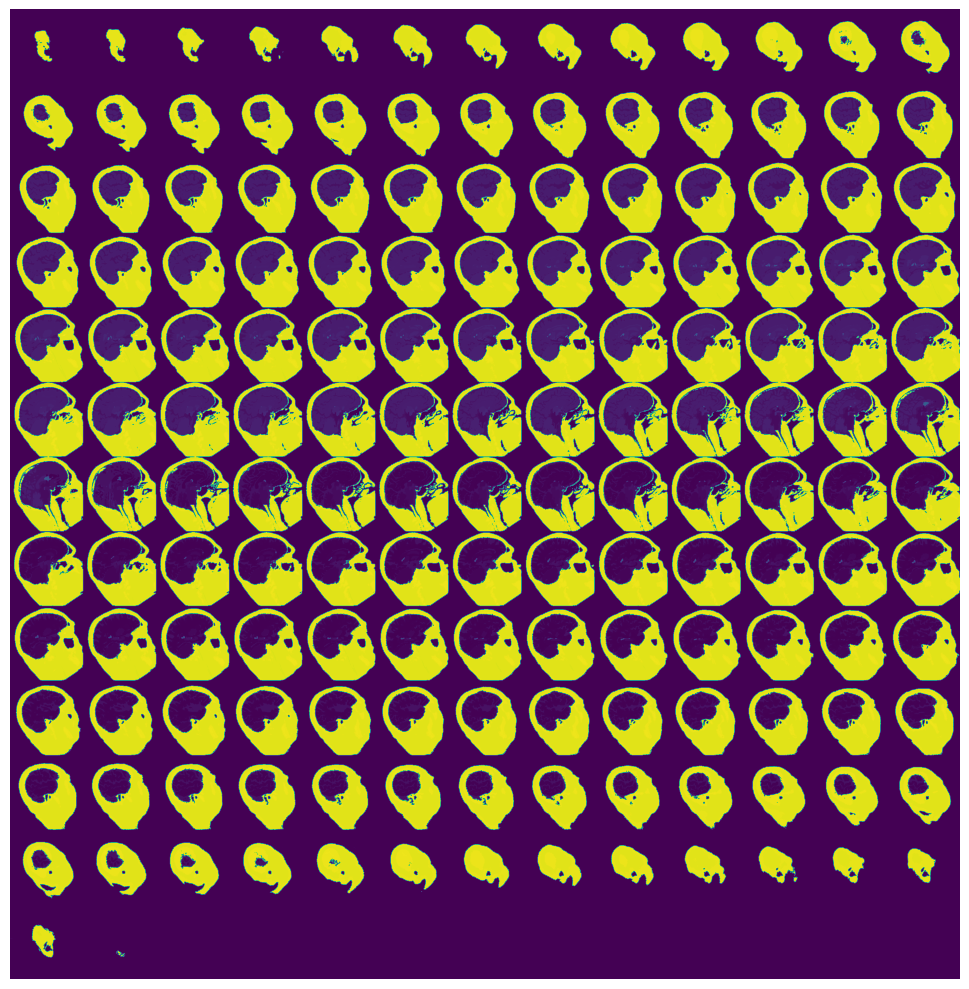

[  0.   2.   3.   4.   5.   7.   8.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  24.  25.  26.  28.  30.  41.  42.  43.  44.  46.  47.  49.
  50.  51.  52.  53.  54.  57.  58.  60.  62.  72.  85. 136. 137. 163.
 164. 502. 506. 507. 508. 509. 511. 512. 514. 515. 516. 530.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 511.
 511. 511. 511. 507. 507. 507. 507. 507. 515. 515. 515. 515. 516. 515.
  24. 514. 514.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.
  24.  24.  42.  42.  42.  42.  42.  42.   3.   3.  24.  24.   3.   3.
  42.  42.  24.  42.  42.  42.  42.  24.  24.  24.  24.  24.  24.  24.
  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.  24.
  24.  24.  24.  24.  24.  24.  24.  16.  16.  16.  16.  16.  16.  16.
  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.
  16.  16.  16.  16.  16.  16.  16.  24.  24.  24.  24.  24.  24. 516.
 516. 516. 516.

In [16]:
nifti_file = '../babytrainingdata/synthseg_sample01.nii.gz'
img = nib.load(nifti_file)

# Get the tensor data from the NIfTI image
tensor1 = img.get_fdata()

# Plot the cropped tensor slices
plot_cropped_tensor_slices(tensor1)
print(np.unique(tensor1))
slice1 = tensor1[128][128]
print(slice1)

In [ ]:
tensor1 = preprocess_label(tensor)
tensor2 = merge_homologs(tensor1)
plot_cropped_tensor_slices(tensor1)
plot_cropped_tensor_slices(tensor2)

In [18]:
assert set(np.unique(tensor)) == set(np.unique(tensor1))